In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pickle

training_file = '/content/drive/My Drive/Colab_Notebooks/train.p'
testing_file = '/content/drive/My Drive/Colab_Notebooks/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train_features, train_labels = train['features'], train['labels']
test_features, test_labels = test['features'], test['labels']

print('Done loading data')

Done loading data


In [3]:
n_train = len(train_features)
n_test = len(test_features)
image_shape = "{}x{}".format(len(train_features[0]), len(train_features[0][0]))
n_classes = max(train_labels) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32
Number of classes = 43


In [4]:
train_labels

array([ 0,  0,  0, ..., 42, 42, 42], dtype=uint8)

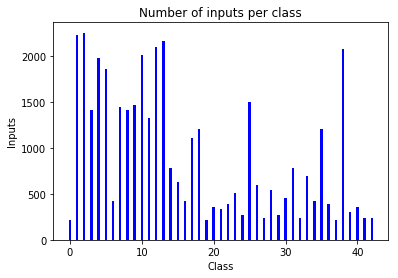

Class:  0


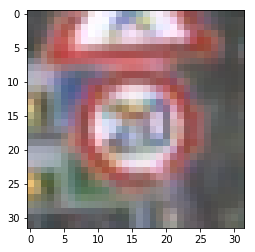

Class:  1


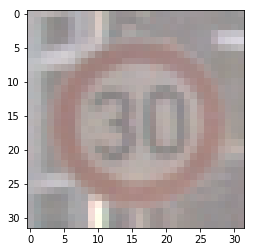

Class:  2


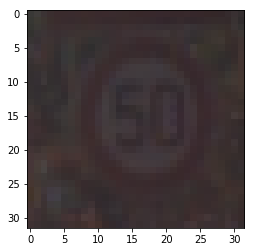

Class:  3


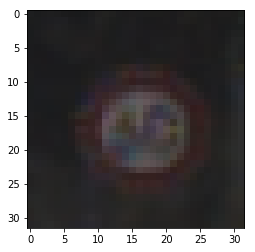

Class:  4


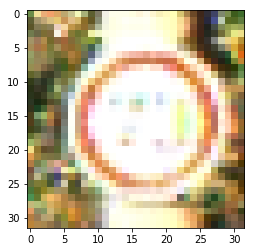

Class:  5


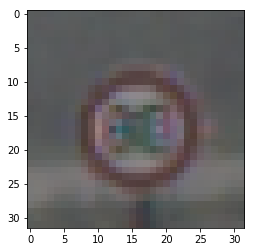

Class:  6


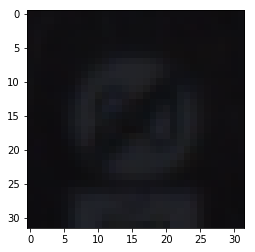

Class:  7


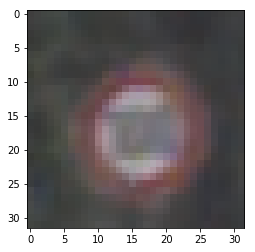

Class:  8


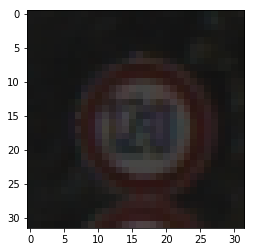

Class:  9


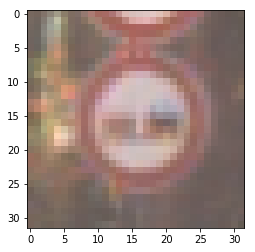

Class:  10


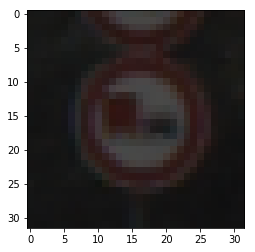

Class:  11


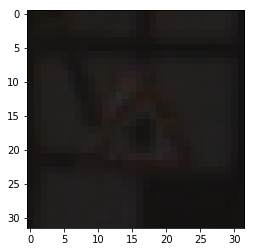

Class:  12


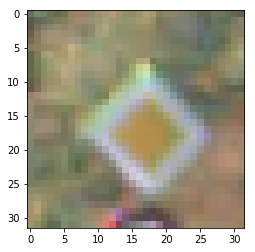

Class:  13


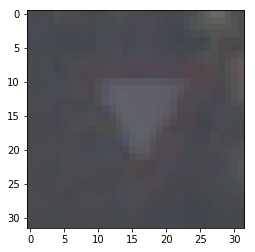

Class:  14


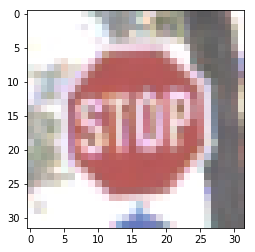

Class:  15


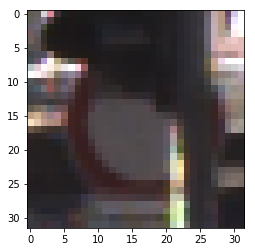

Class:  16


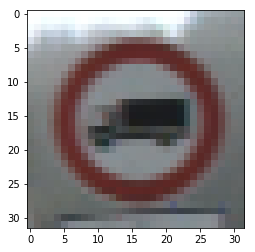

Class:  17


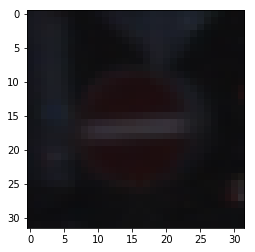

Class:  18


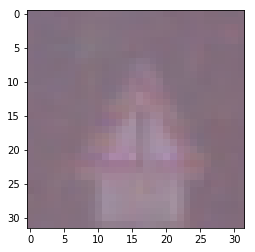

Class:  19


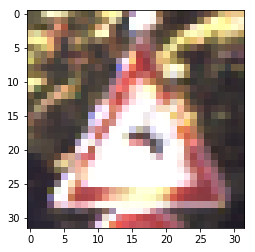

Class:  20


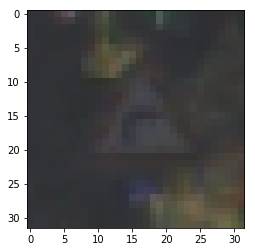

Class:  21


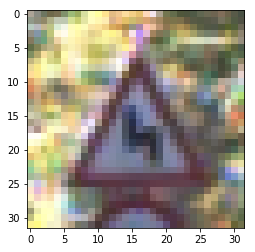

Class:  22


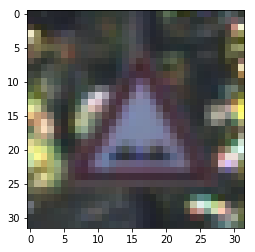

Class:  23


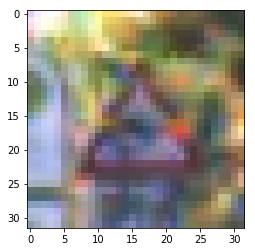

Class:  24


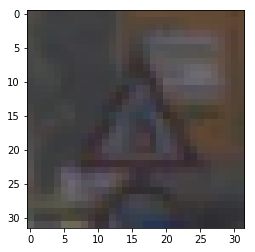

Class:  25


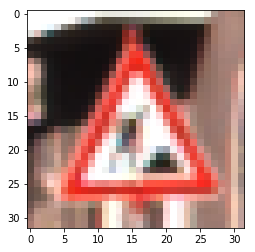

Class:  26


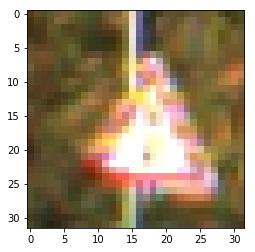

Class:  27


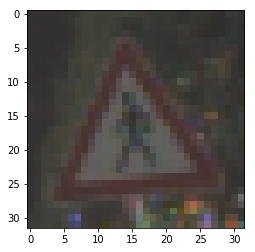

Class:  28


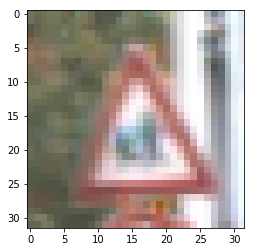

Class:  29


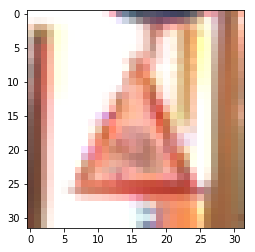

Class:  30


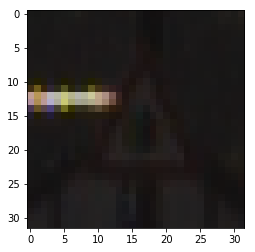

Class:  31


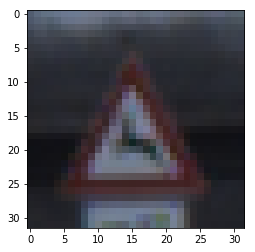

Class:  32


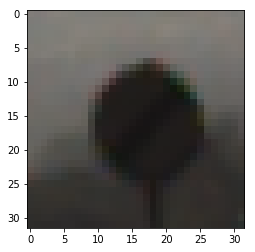

Class:  33


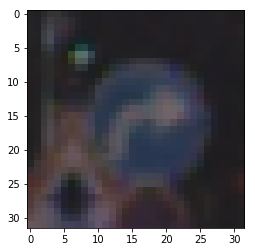

Class:  34


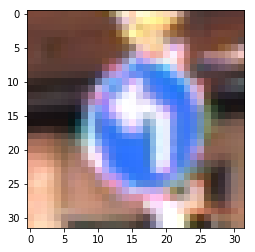

Class:  35


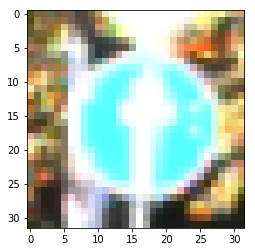

Class:  36


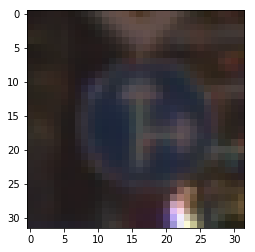

Class:  37


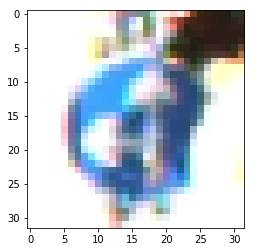

Class:  38


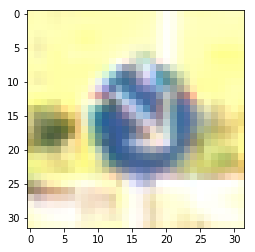

Class:  39


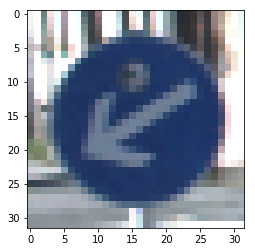

Class:  40


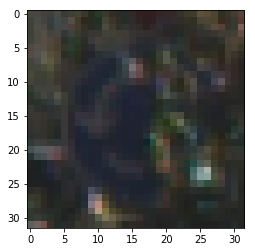

Class:  41


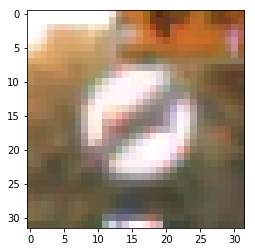

Class:  42


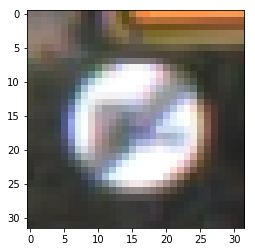

Data visualisation complete


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

train_features = np.array(train['features'])
train_labels = np.array(train['labels'])

inputs_per_class = np.bincount(train_labels)
max_inputs = np.max(inputs_per_class)

mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()

for i in range(n_classes):
    for j in range(len(train_labels)):
        if (i == train_labels[j]):
            print('Class: ', i)
            plt.imshow(train_features[j])
            plt.show()
            break

print('Data visualisation complete')

In [6]:
angles = [-5, 5, -10, 10, -15, 15, -20, 20]

for i in range(len(inputs_per_class)):
    input_ratio = min(int(max_inputs / inputs_per_class[i]) - 1, len(angles) - 1)
    if input_ratio <= 1:
        continue

    new_features = []
    new_labels = []
    mask = np.where(train_labels == i)

    for j in range(input_ratio):
        for feature in train_features[mask]:
            new_features.append(scipy.ndimage.rotate(feature, angles[j], reshape=False))
            new_labels.append(i)

    train_features = np.append(train_features, new_features, axis=0)
    train_labels = np.append(train_labels, new_labels, axis=0)

# Normalize features
print('Normalizing features...')
train_features = train_features / 255. * 0.8 + 0.1

# Get randomized datasets for training and validation
print('Randomizing datasets...')
from sklearn.model_selection import train_test_split
train_features, valid_features, train_labels, valid_labels = train_test_split(
   train_features,
   train_labels,
   test_size=0.2,
   random_state=832289
)

print('Data preprocessed')

Normalizing features...
Randomizing datasets...
Data preprocessed


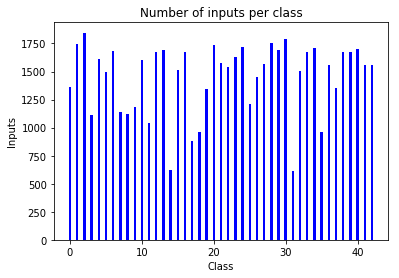

In [7]:
inputs_per_class = np.bincount(train_labels)
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.set_ylabel('Inputs')
ax.set_xlabel('Class')
ax.set_title('Number of inputs per class')
ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
plt.show()

In [8]:
print('Creating network architecture...')
import tensorflow as tf
# Input dimensions
image_width = len(train_features[0][0])
image_height = len(train_features[0])
color_channels = len(train_features[0][0][0])
learning_rate = 0.001

# Convolutional layer patch and output size
filter_width = 3
filter_height = 3
conv_k_output = 128

# Dimension parameters for each fully connected layer
fc_params = [
    image_width * image_height * conv_k_output,
    1024,
    1024,
    n_classes
]

# Build weights and biases
conv2d_weight = None
conv2d_bias = None
fc_weights = []
fc_biases = []

with tf.variable_scope('TRAFFIC', reuse=False):
    conv2d_weight = tf.get_variable("conv2w", shape=[filter_width, filter_height, color_channels, conv_k_output], initializer=tf.contrib.layers.xavier_initializer())
    conv2d_bias = tf.get_variable("conv2b", shape=[conv_k_output], initializer=tf.contrib.layers.xavier_initializer())
    
    for i in range(len(fc_params) - 1):
        fc_weights.append(tf.get_variable('fc_weight' + str(i), shape=[fc_params[i], fc_params[i + 1]], initializer=tf.contrib.layers.xavier_initializer()))
        fc_biases.append(tf.get_variable('fc_bias' + str(i), shape=[fc_params[i + 1]], initializer=tf.contrib.layers.xavier_initializer()))

# One-hot encoded training and validation labels
oh_train_labels = tf.one_hot(train_labels, n_classes).eval(session=tf.Session())
oh_valid_labels = tf.one_hot(valid_labels, n_classes).eval(session=tf.Session())

# Input placeholders
input_ph = tf.placeholder(tf.float32, shape=[None, image_width, image_height, color_channels])
labels_ph = tf.placeholder(tf.float32)

# Convolutional layer
network = tf.nn.conv2d(input_ph, conv2d_weight, strides=[1, 1, 1, 1], padding='SAME')
network = tf.nn.bias_add(network, conv2d_bias)
network = tf.nn.relu(network)

# Fully connected layers
for i in range(len(fc_weights)):
    network = tf.matmul(tf.contrib.layers.flatten(network), fc_weights[i]) + fc_biases[i]
    if i < len(fc_weights) - 1: # No relu after last FC layer
        network = tf.nn.relu(network)

# Loss computation
prediction = tf.nn.softmax(network)
cross_entropy = -tf.reduce_sum(labels_ph * tf.log(prediction + 1e-6), reduction_indices=1)
loss = tf.reduce_mean(cross_entropy)

# Accuracy computation
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels_ph, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Network architecture created')

Creating network architecture...

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Network architecture created


In [9]:
test_features = np.array(test_features) / 255 * 0.8 + 0.1
oh_test_labels = tf.one_hot(test_labels, n_classes).eval(session=tf.Session())
print('Test label one hot encoded')

Test label one hot encoded


In [10]:
batch_size = 150

def run_batch(session, network, features, labels):
    batch_count = int(len(features) / batch_size)
    accuracy = 0
    
    for i in range(batch_count):
        batch_start = i * batch_size
        accuracy += session.run(
            network,
            feed_dict={
                input_ph: features[batch_start:batch_start + batch_size],
                labels_ph: labels[batch_start:batch_start + batch_size]
            }
        )
    
    return accuracy / batch_count

print('Run batch function created')

Run batch function created


Instructions for updating:
Use tf.cast instead.


Epoch 20/20: 100%|██████████| 416/416 [00:31<00:00, 13.37batches/s]


Final validation accuracy:  0.9844871891232637
Final test accuracy:  0.8708730162609191


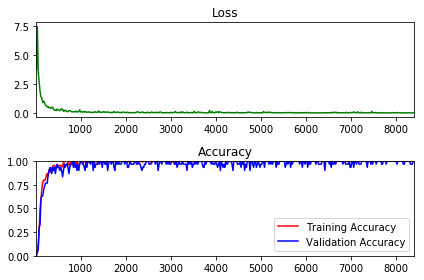

In [11]:
from tqdm import tqdm

training_epochs = 20
optimizer = tf.train.AdamOptimizer().minimize(loss)

log_batch_step = 20
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []
validation_accuracy = 0.0

init = tf.global_variables_initializer()

session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session.run(init)
batch_count = int(len(train_features) / batch_size)

for epoch in range(training_epochs):
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch + 1, training_epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        batch_start = batch_i * batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = oh_train_labels[batch_start:batch_start + batch_size]

        _, l = session.run(
            [optimizer, loss],
            feed_dict={input_ph: batch_features, labels_ph: batch_labels})

        if not batch_i % log_batch_step:
            training_accuracy = session.run(
                accuracy,
                feed_dict={input_ph: batch_features, labels_ph: batch_labels}
            )

            idx = np.random.randint(len(valid_features), size=int(batch_size * .2))

            validation_accuracy = session.run(
                accuracy,
                feed_dict={input_ph: valid_features[idx,:], labels_ph: oh_valid_labels[idx,:]}
            )

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)


validation_accuracy = run_batch(session, accuracy, valid_features, oh_valid_labels)    
test_accuracy = run_batch(session, accuracy, test_features, oh_test_labels)

print('Final validation accuracy: ', validation_accuracy)
print('Final test accuracy: ', test_accuracy)
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

Instructions for updating:
Use the `axis` argument instead
Accuracy on Test-Set: 87.1% (10995 / 12630)
Confusion Matrix:


<Figure size 2880x2880 with 0 Axes>

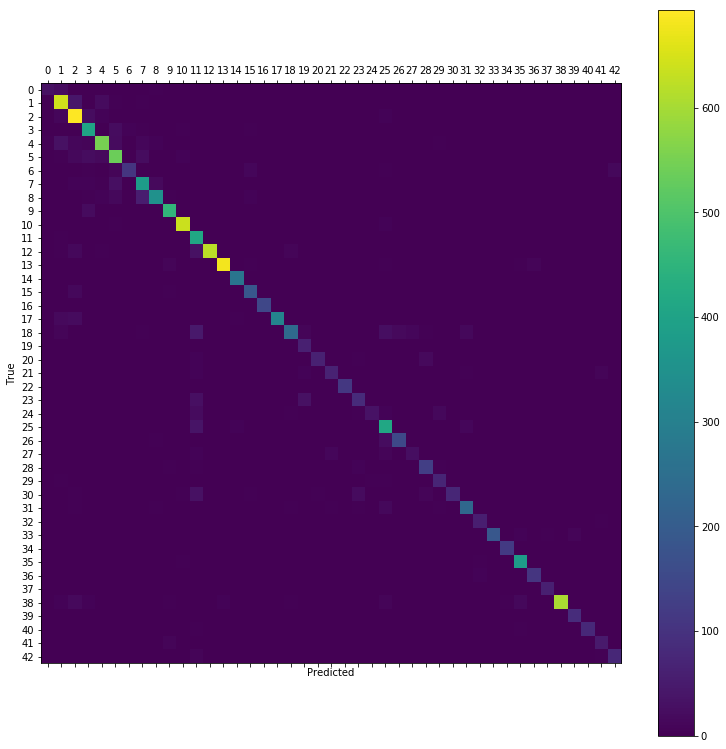

In [12]:
test_batch_size = 250
y_pred_cls = tf.argmax(prediction, dimension=1)
test_cls = np.argmax(oh_test_labels, axis=1)
from pylab import rcParams
from sklearn.metrics import confusion_matrix

img_shape = (32, 32, 3)
    
def plot_confusion_matrix(cls_pred):
    cm = confusion_matrix(y_true=test_cls,
                          y_pred=cls_pred)

    plt.figure(figsize=(40,40))
    rcParams['figure.figsize'] = 13, 13
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    
def print_test_accuracy(show_confusion_matrix=True):

    num_test = len(test_features)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        batch_features = test_features[i:j]
        batch_labels = oh_test_labels[i:j]
        
        feed_dict={input_ph: batch_features, labels_ph: batch_labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    correct = (test_cls == cls_pred)
    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))


    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

print_test_accuracy(show_confusion_matrix=True)